## In this use-case, we demonstrate the capability of the CCP-tool to learn and predict regionalized projection volume data from wild-type and cre-line tract tracing experiments derived from the Allen Mouse Brain Connectivity Atlas, using gene expression data derived from the Allen Brain Atlas ISH coronal experiments, but this time by reducing their redundancy and dimensionality:   
### this is achieved through the Dictionary learning and Sparse coding technique that represents the high dimensional gene expression data as a set of basis vectors represented in brain space (dictionaries) whose variance is driven by sparse linear combination of genes (atoms).   
### This representation is done in two ways, one by using the ISH data exclusively, and one by integrating cell-type specific RNA sequencing data from the Neuroexpresso repository hence creating constrained cell-type driven dictionaries. Using this representation, we push the CCP-tool to minimized the genetic information needed to predict mesoscale connectivity patterns in the mouse brain.

## Beginnings:
### Load all necessary ingredients from the storage

## Step 0: 
### Import the libraries / initialize the pipeline

In [1]:
import os
from subprocess import call
import pickle as pk
from IPython.display import clear_output
current_dir = os.listdir('./')
for path in os.listdir('../25 3 2019/'):
    if os.path.islink(path) is not True and path not in current_dir:
        call(['ln','-s','../25 3 2019/'+ path, path])        
from cfg import *
os.chdir('../CCP_Collab_Backup_2/')
import PrimaryLibrary as PL
imp.reload(PL)
import MorphologyLibrary as MLab
imp.reload(MLab)
import Allen_API_Library as API
imp.reload(API)
MesoPred = PL.MesoconnectomePredictor()

importing Jupyter notebook from Allen_API_Library.ipynb
importing Jupyter notebook from Allen_API_Library.ipynb


## Step I: Initialization 
### Load and Preprocess the unionized data

In [2]:
GeneExp  = h5py.File('G_Exp.hdf5', 'r')['dataset1']
ConDict  = pk.load(open('CreLineDict.pkl','rb'))

ConMat_scaled = OrderedDict()
for key in ConDict.keys():
    GeneExp_scaled,g_scaler,ConMat_scaled[key],c_scaler  = MesoPred.PreProcessing(GeneExp[MesoPred.params['leaf_keys'],:], 
                                      MesoPred.params,
                                      ConDict[key]['ConMat'][MesoPred.params['leaf_keys'],:])
         
GeneMeta       = pk.load(open('GeneMeta.pkl','r'))
clear_output()

## Section 0: 1st form of predictions, individual gene expression based predictions  
### This form of predictions has been demonstrated in the CCP Pipeline and highlighted in the first three use-cases, wherein the expression energy of individual genes , obtained by the Allen Mouse Brain Atlas ISH coronal sections, has been used by the CCP model to learn and predict projection patterns from bulk tracing experiments, wild-type and cre-line based.  
### Loading the results from the CCP Pipeline notebook (predictions using individual gene expression values) for comparative purposes

In [3]:
ClfResults_ridge = {} 
for key in MesoPred.ConDict.keys():
    if os.path.isfile(MesoPred.params['prefix'] + key + '_all_results' + '_total.pkl') == True:
        infile = MesoPred.params['prefix'] + key + '_all_results' + '_total.pkl'
        #infile = key + '_all_results' + '_ridge.pkl'
        print infile
        tmp = pk.load(open(infile,'rb'))
        ClfResults_ridge[key] = {key:val for key,val in tmp['ridge'].items()}

gene_scores = [r2 for key in ClfResults_ridge.keys() for r2 in ClfResults_ridge[key]['r2']]
clear_output()      

#### To speed-up the demonstration, the resulting dictionaries are being loaded through pickle files.   
#### In case that the full iteration of the process is desired, click on the cell below and change its form from "Raw NBConvert" to "Code" 

In [4]:
#Check whether a transpose operation is needed
Code, Atoms, dlsc_mdl = MesoPred.DictionaryDecomposition(GeneExp_scaled.T, n_comp = 200)  
Code = Code.T; Atoms = Atoms.T
print Atoms.shape, Code.shape
pk.dump(Atoms, open('Atoms.pkl', 'wb'))
pk.dump(Code, open('Code.pkl', 'wb'))
pk.dump(dlsc_mdl, open('dlsc_mdl.pkl', 'wb'))  

Commencing dictionary decomposition ...
(3318, 200) (200, 428)
Atoms : (200, 428)
Code : (3318, 200)
Sparsity: 0.0559071729958
Participation: 0.511682242991
Error: 222.9164185636903
Elapsed time: 20.6078514338
(200, 3318) (428, 200)


In [4]:
Atoms = pk.load(open('Atoms.pkl', 'rb'))
Code = pk.load(open('Code.pkl', 'rb'))

 # Section 1: 2nd form of predictions  - unconstrained module predictions
### Predictions using sparse co-expression modules/dictionaries across brain areas, with the genes being obtained by the Allen Mouse Brain Atlas coronal ISH sections (Lein et al, 2007). The dictionaries have been estimated using the Dictonary learning and Sparse coding method (see links in Overview)  
 ### In the cell below, the dictionaries are being used by the CCP model to learn and predict the normalized projection volume across all wild-type bulk tracing experiments

In [5]:
module_based_pred, all_scores = PL.Predictive_Shortcut(ConMat_scaled, Code)   
top_perf_per_cre = [(key, np.argmax(module_based_pred[key]['r2']),np.max(module_based_pred[key]['r2']))\
                    for key in module_based_pred.keys()]
clear_output()
print top_perf_per_cre

[('Nr5a1-Cre', 10, 0.6607487551280686), ('Scnn1a-Tg3-Cre', 26, 0.6724271306159914), ('Ntsr1-Cre_GN220', 3, 0.6627301336653268), ('Emx1-IRES-Cre', 11, 0.7244573930328528), ('Efr3a-Cre_NO108', 4, 0.6444670701090915), ('Rbp4-Cre_KL100', 45, 0.7616578807044091), ('Sim1-Cre_KJ18', 3, 0.7006128059237238), ('Chrna2-Cre_OE25', 26, 0.7342210059538754), ('Sepw1-Cre_NP39', 8, 0.6744275251106413), ('Tlx3-Cre_PL56', 60, 0.7316988825950098), ('Cux2-IRES-Cre', 22, 0.7669761158057551), ('A93-Tg1-Cre', 17, 0.6972153555324463), ('Rorb-IRES2-Cre', 21, 0.7148998849182565), ('wild_type', 76, 0.7926797110976375), ('Syt6-Cre_KI148', 17, 0.6529431875934864)]


### Codify_Modules takes a set of dictionaries and a set of projection patterns and color-codes their spatial overlap through cortical-subcortical visualizations in 3D brain space

In [6]:
def Codify_Modules(Code, Proj_pat, code_set):
    new_code = np.zeros((len(Code),1))
    for area in range(len(Code)):
        mod_sub = [Code[area,subset] for subset in code_set]
        nonzero_mods = np.nonzero(mod_sub)[0]
        if Proj_pat[area] > 0 and len(nonzero_mods) > 0:
            if len(nonzero_mods) == 1:
                new_code[area] = 0.6    
            elif len(nonzero_mods) == 2:
                new_code[area] = 0.8
            elif len(nonzero_mods) == 3:
                new_code[area] = 1.0    
        elif Proj_pat[area] > 0 and len(nonzero_mods) == 0:
            new_code[area] = 0.4
        elif Proj_pat[area] <= 0 and len(nonzero_mods) > 0:
            new_code[area] = 0.2
        else:
            new_code[area] = 0
            
    return new_code            


### Following the general dictionary-based predictions, we move on to a strict subset selection: repeating predictions with only three dictionaries, selected based on pairwise correlations between projection patterns and dictionaries, will allow us to assess the minimum number of dictionaries needed to explain the variance across the bulk tracing experiments, wild-type and cre-line based ones.

In [7]:
#while True:
exp_to_mod_cor = {}
flag = 0
# Rinse and repeat for all tracing experiments
for key in ConMat_scaled.keys():
    exp_to_mod_cor[key] = {'local correlations' : [], 'global correlations' : [], 
                           'top_mods' : [],'pval' : [], 'y_pred': [], 'top_three_r2' : []}
    for inj in range(len(ConMat_scaled[key][0])):
        temp = [abs(sci.stats.pearsonr(ConMat_scaled[key][:,inj], Code[:,idx])[0]) for idx in range(len(Code[0]))]
        top_mods = np.argsort(temp)[::-1][0:3]
        module_based_pred_local, all_scores_local = PL.Predictive_Shortcut(ConMat_scaled, Code[:,top_mods], 
                                                            key = key, exp_id = inj) 
        corr = sci.stats.pearsonr(ConMat_scaled[key][:,inj], module_based_pred_local[key]['y_pred'])
        exp_to_mod_cor[key]['local correlations'].append(np.sort(temp)[::-1][0:3])
        exp_to_mod_cor[key]['global correlations'].append(corr[0])
        exp_to_mod_cor[key]['pval'].append(corr[1])
        exp_to_mod_cor[key]['top_mods'].append(top_mods)
        exp_to_mod_cor[key]['y_pred'].append(module_based_pred_local[key]['y_pred'])
        exp_to_mod_cor[key]['top_three_r2'].append(module_based_pred_local[key]['r2'])
   
clear_output()
all_mod_to_proj_cor = [corr for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['global correlations']]
print np.median(all_mod_to_proj_cor) - sci.stats.iqr(all_mod_to_proj_cor), np.median(all_mod_to_proj_cor) + sci.stats.iqr(all_mod_to_proj_cor)

0.4009782323315069 0.6771155703439029


### Creation of a histogram with the pearson correlation between all projection patterns and their reconstruction from top three dictionaries, as to show the efficacy of using only a small subset of dictionaries to predict/reconstruct normalized projection volumes across bulk tracing experiments

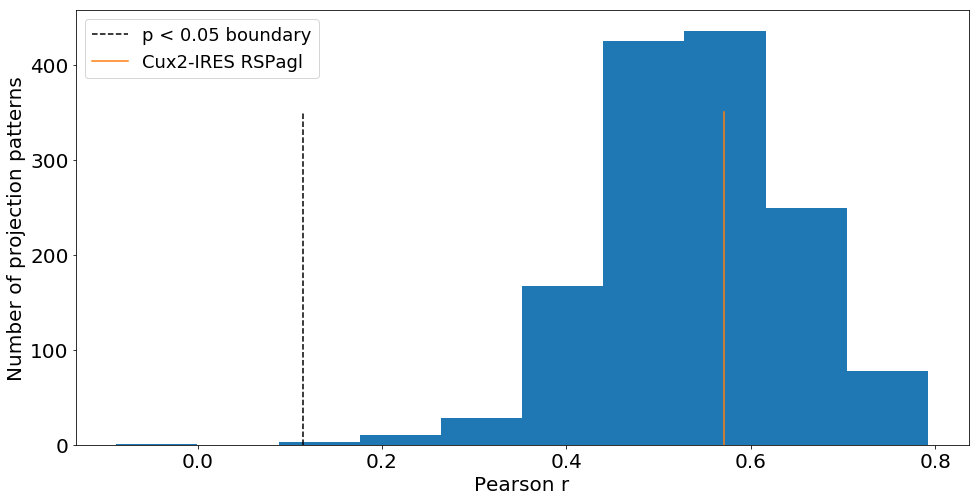

In [9]:
all_mod_to_proj_cor = [corr for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['global correlations']]
all_mod_to_proj_p = [corr for key in exp_to_mod_cor.keys() for corr in exp_to_mod_cor[key]['pval']]
fig = plt.figure(figsize = (16,8))
plt.hist(all_mod_to_proj_cor)
ax = plt.gca()
threshold = all_mod_to_proj_cor[np.argsort(all_mod_to_proj_p)[::-1][1]]
sel_point = exp_to_mod_cor['Cux2-IRES-Cre']['global correlations'][57]
ax.plot([threshold, threshold], [0, 350], "k--")
ax.plot([sel_point, sel_point], [0, 350])
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
plt.xlabel('Pearson r',fontsize = 20)
plt.ylabel('Number of projection patterns',fontsize = 20)
plt.legend(['p < 0.05 boundary','Cux2-IRES RSPagl'], fontsize = 18, loc = 'upper left')

### Visualizations of the strongest correlated pairs between gene dictionaries and projection patterns. The first subcortical-cortical visualizations represent the selected projection pattern, the second ones represent the colorcoding overlay plot between the projection patterns and its top three dictionary predictors and the following visualizations represent the top three dictionary predictors in brain space

The 57th injection experiment (Retrosplenial agranular area from Cux2-cre-line, has been selected due to its r2 predictive score being the highest (r2 > 0.77))

In [10]:
sel_mods = exp_to_mod_cor['Cux2-IRES-Cre']['top_mods'][57]
new_code = Codify_Modules(Code, ConMat_scaled['Cux2-IRES-Cre'][:,57], sel_mods)

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


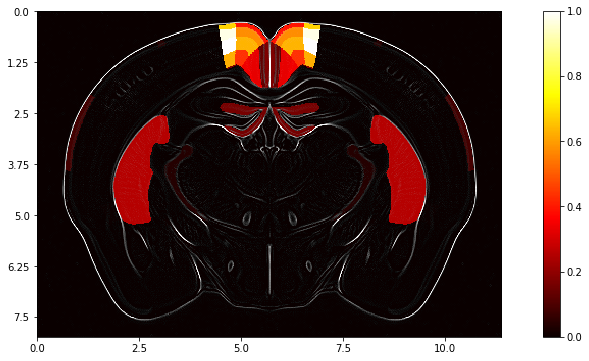

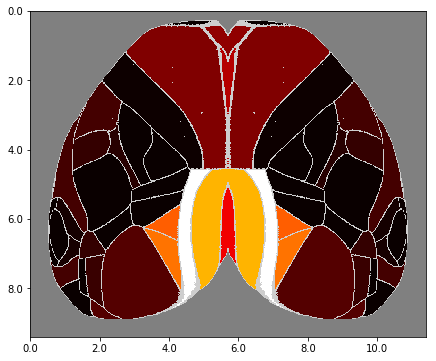

visualization of RSPagl has been completed


In [11]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_10 = PL.BrainPlotter(resolution = 10)
BP_25.fit(projection = ConMat_scaled['Cux2-IRES-Cre'][:,57], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_10.fit(projection = ConMat_scaled['Cux2-IRES-Cre'][:,57], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice()
BP_10.plot_flatmap()
print 'visualization of {} has been completed'.format(MesoPred.ConDict['Cux2-IRES-Cre']['structure-abbrev'][57])

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


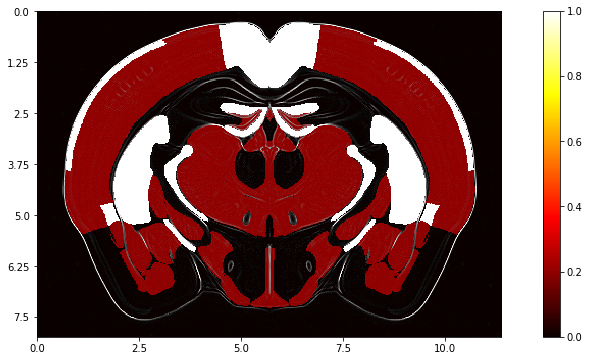

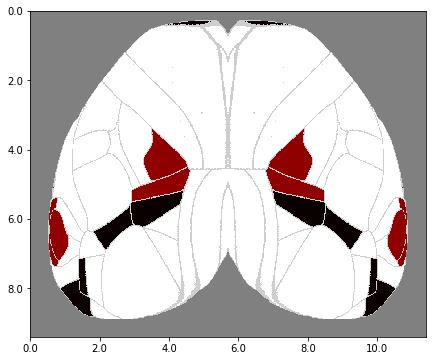

visualization of RSPagl new code has been completed


In [12]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_10 = PL.BrainPlotter(resolution = 10)
BP_25.fit(projection = new_code[:,0], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_10.fit(projection = new_code[:,0], 
          chosen_indices = MesoPred.params['remaining_indices'])
BP_25.plot_slice()
BP_10.plot_flatmap()
print 'visualization of RSPagl new code has been completed' 

58
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


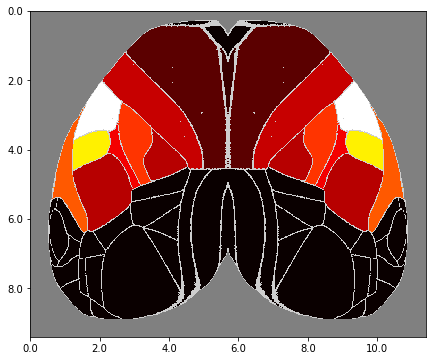

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


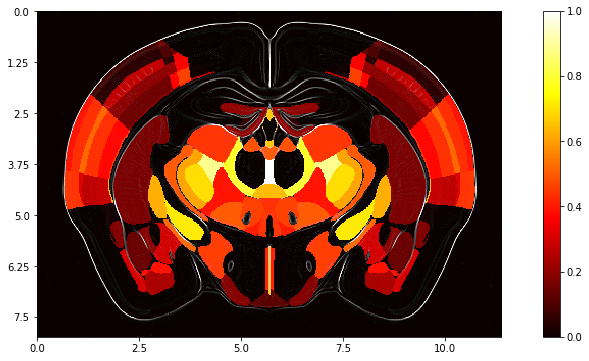

visualization of module 58 new code has been completed
39
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


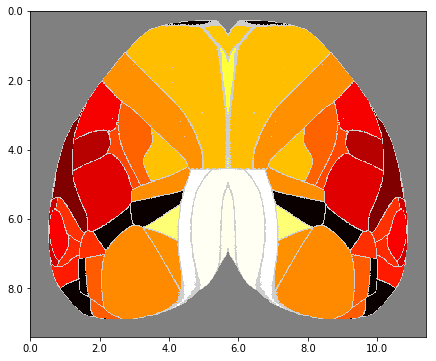

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


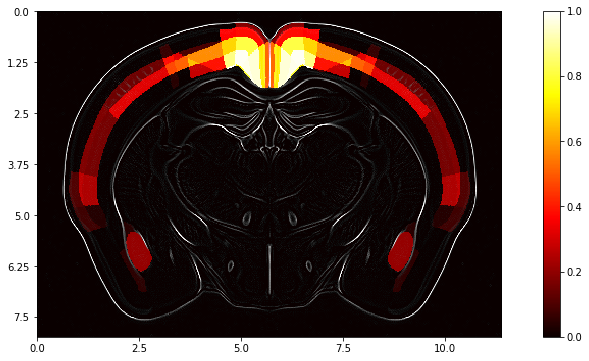

visualization of module 39 new code has been completed
81
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


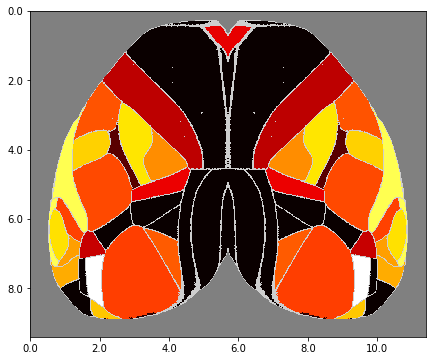

/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2
/home/ntimonidis/Brain-Connectivity Project/CCP_Collab_Backup_2


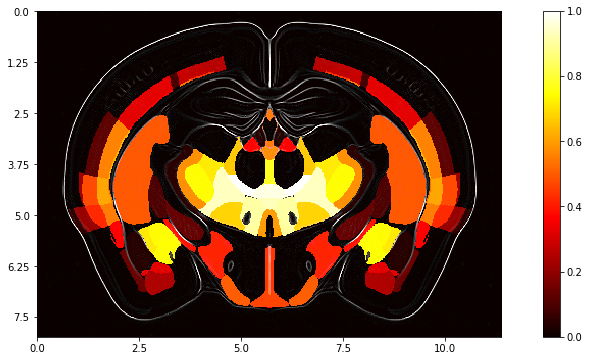

visualization of module 81 new code has been completed


In [13]:
for mod in sel_mods:
    print mod
    BP_10 = PL.BrainPlotter(resolution = 10)
    BP_10.fit(projection = Code[:,mod], chosen_indices = MesoPred.params['remaining_indices'])
    BP_10.plot_flatmap()
    BP_25 = PL.BrainPlotter(resolution = 25)
    BP_25.fit(projection = Code[:,mod], 
              chosen_indices = MesoPred.params['remaining_indices'])
    BP_25.plot_slice()
    print 'visualization of module {} new code has been completed'.format(mod) 

# Section 2: 3rd form of predictions  - constrained module predictions
### Predictions using sparse co-expression modules/dictionaries across brain areas, with the genes being obtained by the Allen Mouse Brain Atlas coronal ISH sections (Lein et al, 2017), the dictionaries being estiamted by the Dictionary learning and Sparse Coding method and constrained by cell-type specific RNA seq data obtained from the Neuroexpresso repository, in order to form modules that are as close to cell-type-specific densities as possible

### Cell-type RNA seq data data have been retrieved from Neuroexpresso github page:
https://github.com/PavlidisLab/neuroExpressoAnalysis

In [8]:
infile = 'n_expressoExprWithRNAseq.csv'
CelltypeMat, gene_annot,cell_annot = PL.CellTypeParser(infile)

sg_cell_annot, sg_cell_id = np.unique(gene_annot, return_index = True)
ish_annot, ish_id         = np.unique(MesoPred.params['Gene Acronyms Original'], return_index = True)
tmp                       = set.intersection(set(ish_annot),set(sg_cell_annot))
ish_id2      = [ish_id[idx] for idx,val in enumerate(ish_annot) if val in tmp]
sg_cell_id2  = [sg_cell_id[idx] for idx,val in enumerate(sg_cell_annot) if val in tmp]

ish_data     = GeneExp_scaled[:,ish_id2]
sg_cell_data = np.transpose(CelltypeMat[sg_cell_id2,:])
sg_cell_data = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0, verbose=0, \
                       copy=True).fit_transform(sg_cell_data)

potential_ct = [idx for idx,val in enumerate(cell_annot) if 'GSM' not in val]

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Creation of the constrained gene dictionaries by integrating the neuroexpresso cell-type RNA seq data

In [16]:
G_Code, G_Atoms, G_dlsc = MesoPred.DictionaryDecomposition(np.transpose(ish_data), 
                                                           x = np.transpose(sg_cell_data[potential_ct,:]), 
                                                           n_comp = np.shape(sg_cell_data[potential_ct,:])[0],
                                                           alpha = 0.1, state = 123)
G_Atoms = np.transpose(G_Atoms); G_Code = np.transpose(G_Code) 
clear_output()

pk.dump(G_Atoms,open('Grange_Atoms.pkl', 'wb'))
pk.dump(G_Code,open('Grange_Code.pkl', 'wb'))
pk.dump(G_dlsc,open('Grange_mdl.pkl', 'wb'))

### Prediction of unionized projection patterns using the constrained gene dictionaries

In [8]:
G_Atoms = pk.load(open('Grange_Atoms.pkl', 'rb'))
G_Code  = pk.load(open('Grange_Code.pkl', 'rb'))
G_dlsc  = pk.load(open('Grange_mdl.pkl', 'rb'))

g_module_based_pred, g_all_scores = PL.Predictive_Shortcut(ConMat_scaled, G_Code) 

clear_output()

### Formation of a pairwise correlation matrix between constrained and unconstrained dictionaries 

In [9]:
SimMat_cor = np.zeros((len(Code[0]), len(G_Code[0])))
pval_cor = np.zeros((len(Code[0]), len(G_Code[0])))
G_Code_sc = StandardScaler().fit_transform(G_Code)
Code_sc = StandardScaler().fit_transform(Code)
for ctype in range(len(G_Code[0])):
    for module in range(len(Code[0])):
        SimMat_cor[module,ctype] = sci.stats.spearmanr(G_Code_sc[:,ctype],
                                                   Code_sc[:,module])[0]
        tmp = sci.stats.spearmanr(G_Code[:,ctype], Code[:,module])
        SimMat_cor[module,ctype] = tmp[0]
        pval_cor[module,ctype] = tmp[1]
        clear_output()  

### Finding associations between the two decompositions by biclustering their correlation matrix 

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/cluster/bicluster.py:509: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for label in range(n_row_clusters)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/sklearn/cluster/bicluster.py:512: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for _ in range(n_row_clusters)


Text(0.5,46,'Constrained Modules')

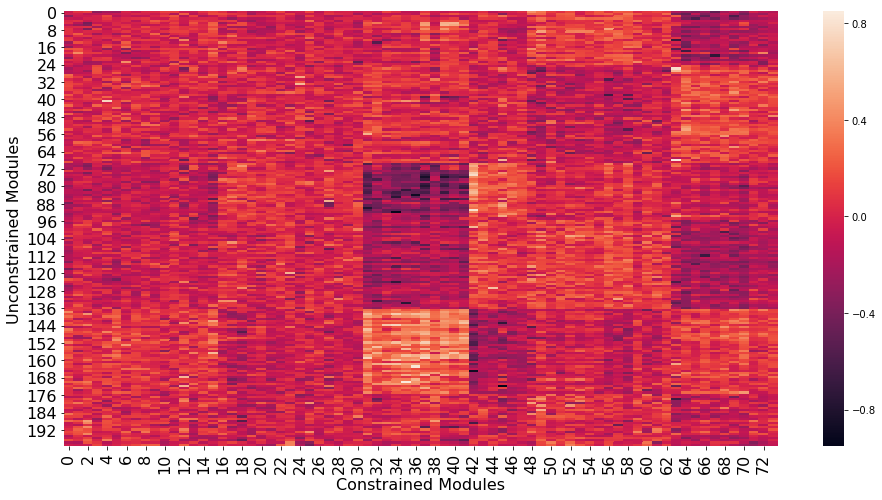

In [10]:
from sklearn.cluster import bicluster
module_biclsusters = bicluster.SpectralBiclustering(n_clusters = 6, random_state = 0)
module_biclsusters.fit(SimMat_cor)
row_labels = module_biclsusters.row_labels_
column_labels = module_biclsusters.column_labels_

sorted_SimMat = np.zeros(np.shape(SimMat_cor))
row_reorder = []; column_reorder = []
for row in np.unique(row_labels):
    row_reorder.extend([idx for idx,val in enumerate(row_labels) if val == row])
for column in np.unique(column_labels):
    column_reorder.extend([idx for idx,val in enumerate(column_labels) if val == column])
    
sorted_SimMat = SimMat_cor[row_reorder,:]
sorted_SimMat = sorted_SimMat[:,column_reorder]
fig = plt.figure(figsize = (16,8))
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
sns.heatmap(sorted_SimMat)
plt.ylabel('Unconstrained Modules', fontsize = 16)
plt.xlabel('Constrained Modules', fontsize = 16)

### Pairwise boxplots of predictive performance for the three different forms of CCP-based predictions:   
#### 1) predictions using the expression energy of individual genes across brain areas, with the genes being obtained by the Allen Mouse Brain Atlas ISH coronal experiments (Lein et al, 2007)
#### 2) predictions using sparse co-expression modules/dictionaries across brain areas, with the genes being obtained as shown above and the dictionaries being estimated by the Dictionary learning and Sparse coding method.
#### 3)  predictions using sparse co-expression modules/dictionaries across brain areas, with the genes being obtained as shown above and the dictionaries being constrained by cell-type specific RNA seq data obtained from the Neuroexpresso repository

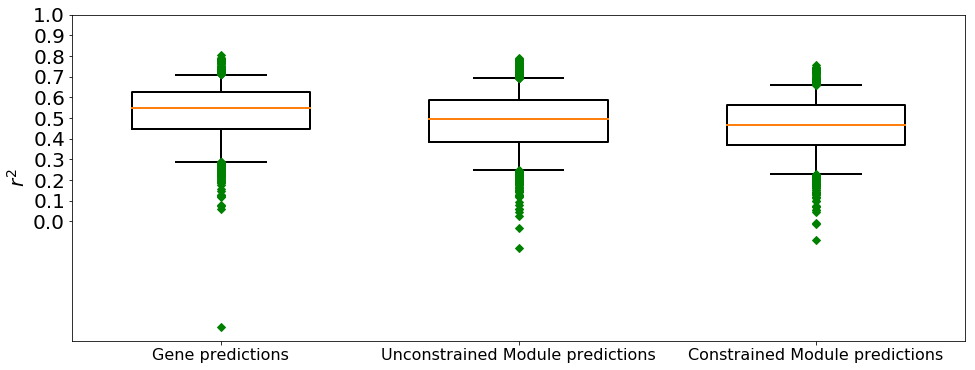

In [11]:
fig = plt.figure(figsize = (16,6))
ax = plt.gca()
#plt.tight_layout()
#plt.rcParams['figure.figsize']
plt.rcParams['axes.facecolor'] = 'white'
box = plt.boxplot([gene_scores, all_scores, g_all_scores], 0, 'gD', widths = 0.6, whis = [5,95])
for key in box.keys():
        for bp in box[key]:
            bp.set(linewidth = 2)
plt.yticks(np.arange(0.0,1.1,0.1))
ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 20)
plt.xticks([1,2,3],['Gene predictions', 'Unconstrained Module predictions', 'Constrained Module predictions'])
plt.ylabel(r'$r^2$', fontsize = 20)
plt.show()

### Performing Gene Ontology (GO) Enrichment Analysis for assessing the functional annotations of the identified modules/dictionaries related to neuronal function, through accessing the Org.Mm.Eg database  
### This is a three-fold process: 
##### first: identification of the projection pattern with the highest predictive accuracy (r2),
#### second: identification of the highest predictive dictionaries based on their coefficients (percentile < 1% and percentile > 99%)
#### third: collection of genes with non-zero value for these dictionaries and formation of a unique set
#### fourth: application of the hypergeometric test (p < 0.001)  
Note: When testing the GOenrichment function, the binding from python to R returns results that vary across different versions of R, and therefore it is suggest it to run it directly using R in case that an error occurs

In [ ]:
Ontology_per_module = OrderedDict()

# 1: picking the top three predictions
top_3_preds = np.sort(all_scores)[::-1][0:3]
top_3_tuples = [(key,idx) for key,value in module_based_pred.items() \
                for idx,r2 in enumerate(value['r2']) if r2 in top_3_preds]

# for each of the top 3 predicted patterns:
for driver_line,inj_num in top_3_tuples:
    #2: collecting the dictionaries with the highest predictive accuracy based on their coefficients
    coefs_for_pred = module_based_pred[driver_line]['coef'][inj_num,:]
    high_perc_dict = np.percentile(coefs_for_pred,99)
    low_perc_dict  = np.percentile(coefs_for_pred,1)
    # selecting the most predictive dictionaries
    dictionary_predictors = np.concatenate((np.where(coefs_for_pred > high_perc_dict)[0],\
                                            np.where(coefs_for_pred < low_perc_dict)[0]))
    gene_predictors = []
    #3: for each of the dictionaries collect the strongest genes driving the dictionary's variance
    for i,pred_dict in enumerate(dictionary_predictors):
        high_perc_genes = np.percentile(Atoms[pred_dict,:],99)
        low_perc_genes  = np.percentile(Atoms[pred_dict,:],1)
        tmp_list = np.concatenate((np.where(Atoms[pred_dict,:] > high_perc_genes)[0],\
                        np.where(Atoms[pred_dict,:] < low_perc_genes)[0]))
        if i == 0:
            gene_predictors.extend(tmp_list)
        else:    
            gene_predictors.extend(tmp_list)
    # taking the unique set of genes to ensure that we have no duplicates over the selection
    gene_predictors = np.unique(gene_predictors)
    #4: having retrived the gene predictors of interest, lets get their Entrez Id 
    # and perform ontology enrichment analysis on them
    gene_list_entrez_ids  = [MesoPred.params['Gene Ids Original'][val] for val in gene_predictors \
                             if MesoPred.params['Gene Ids Original'][val] is not None]
    predicted_pattern = str(driver_line) + '_module_predictions'
    Ontology_per_module[predicted_pattern] = MesoPred.GOenrichment(gene_list_entrez_ids)
    if len(Ontology_per_module[predicted_pattern].values) > 0:
        PL.render_mpl_table(Ontology_per_module[predicted_pattern])
        print 'for driver line {} injected at {} the strongest dictionary predictors are {}'.format(driver_line, \
                                                   ConDict[driver_line]['structure-abbrev'][inj_num],\
                                                   np.sort(dictionary_predictors))
               

/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Bioconductor version 3.8 (BiocInstaller 1.32.1), ?biocLite for help

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: BioC_mirror: http://bioconductor.org

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using Bioconductor 3.8 (BiocInstaller 1.32.1), R 3.5.1 (2018-07-02).

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Installing package(s) 'GOstats'

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/ntimonidis/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py: